<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

**В данной работе мы будем искать и обучать модель способную разделять комментарии пользователей на позитивные и негативные** <br>
Модель будет использоваться в интернет-магазине "Викишоп", в сервисе, где пользователи могут самостоятельно дополнять и редактировать описание товаров. Модель будет нужна для определения токсичных комментариев и отправки их на модерацию. <br>
Для данной работы мы имеем набор данных с разметкой об их токсичности. Сначала рассмотрим имеющийся датасет и подумаем какая часть данных может нам пригодится. Далее проведем очистку текстовых данных от лишних символов, цифр и пунктуации, разберем комментарии на отдельные токены и проведем лемматизацию текстов. Переведем данные в векторный тип методом TF-IDF. Затем обучим несколько моделей и выберем лучшую. В конце проведем проверку моделй на тестовых данных.<br>
Необходимая мметрика качества работы моделей в данной работе _F1_.



## Обзор данных

Установим и импортируем необходимые компоненты и библиотеки для работы, загрузим имеющиеся данные и посмотрим на них.

In [ ]:
import pandas as pd
import numpy as np

import spacy
from spacy.lang.en import English

stopwords = English.Defaults.stop_words

# from pandas_profiling import ProfileReport
import re

import matplotlib.pyplot as plt
from pylab import rcParams

rcParams["figure.figsize"] = 15, 8

from sklearn.utils import resample, shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier

from sklearn.metrics import f1_score

SEED = 777

In [ ]:
try:
    data = pd.read_csv(
        "..\\Desktop\\Jupiter_and_projects\\data_sets\\toxic_comments.csv"
    )
except:
    data = pd.read_csv("https://code.s3.yandex.net/datasets/toxic_comments.csv")

Как видно из отчета, мы имеем большой датасет на 159 тыс. записей, при этом у него только 3 столбца - текст комментария, метка токсичности и столбец с номером записи по порядку.<br>
Дубликаты в данных отсутсвуют.<br>
Если посмотреть на целевой столбец `toxic` то он имеет распределение бинарного значения о наличии токсичности комментария. При этом в наших данных распределение токсичных и нейтральных комментариев неравномерно, токсичные комментарии составляют около 11% от наших данных.<br>
Сами тексты комментариев представлены на английском языке, содержат знаки препинания, верхний и нижний регистр, цифры и различные абревиатуры. Также комментарии имеют различную длину и количество слов.

## Подготовка данных

Для начала посмотрим какие длины текстовых данных мы имеем и как они распределяются в нашем датасете.

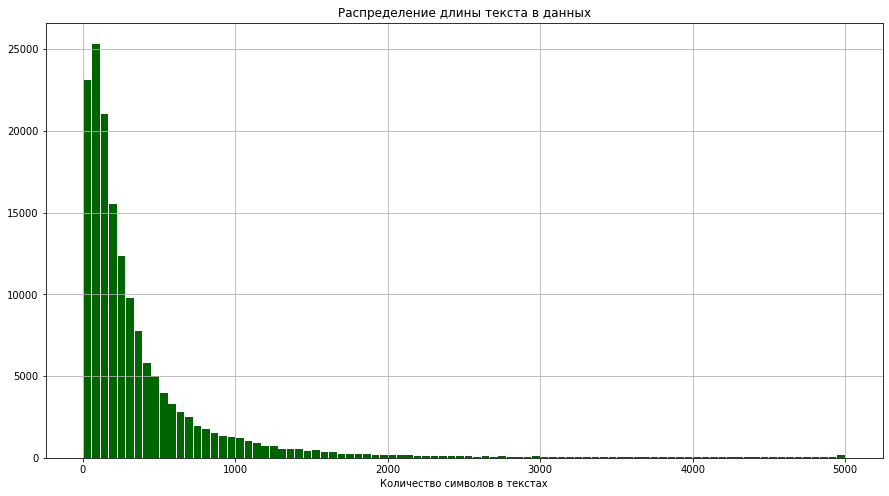

In [ ]:
ax = pd.Series([len(line) for line in data["text"]]).hist(
    color="DarkGreen", bins=90, rwidth=0.9
)
ax.set_title("Распределение длины текста в данных")
ax.set_xlabel("Количество символов в текстах");

Можно заметить, что большинство текстов имееют количество символов меньше 2000, но так же имеются отдельные выбросы с длиной текста до 5000 символов. При наличии большого количества символов мы сильно нагружаем модель и большая размерность вектора может сбивать модель - ограничим нашу выборку текстами, имеющими длину до 2500 символов. 

In [ ]:
indexes = []
i = 0
for line in data["text"]:
    if len(line) > 2500:
        indexes.append(i)
    i += 1
data = data.drop(index=indexes)
data.shape

(156471, 3)

Для коррекного перевода текстов вектора надо обработать сам текст. <br>
Напишем функцию, которая будет делать следующее:
- Оставлять в наших текстах только английские буквенные символы, без цифр и знаков пунктуации;
- Приводить все символы к нижнему регистру;
- Удалять все лишние пробелы;
- Преобразовывать слова в токены и возвращать их леммы.<br>

На выходе мы должны получить массив текстов, готовый к переводу в векторный вид. Для лемматизации слов в текстах воспользуемся моделью из библиотеки spaСy

In [ ]:
nlp = spacy.load("en_core_web_lg")
lemmatizer = nlp.get_pipe("lemmatizer")


def clean_text(array_of_text):
    lemma_full = []

    low_text = [re.sub(r"[^a-z]+", " ", line.lower()) for line in array_of_text]

    doc_for_lemma = list(nlp.pipe(low_text))

    for i in range(len(low_text)):
        lemma_full.append([])
        lemma_full[i] = " ".join([token.lemma_ for token in doc_for_lemma[i]])

    return np.array(lemma_full)

Далее чтобы не нагружать процессы обработки текста сразу выделим данные для обучающей выборки и для тестовой.<br>
Для обучающей части данных составим выборку самостоятельно. Так как в данных присутствует сильный дисбалланс целевого признака, ограничим данные которые пойдут на обучение моделей, таким образом мы дополнительно снизим нагрузку на ядро. Чтобы модель могла справедливо выучить и плохие примеры и хорошие соберем обучающую выборку пополам из 2х классов целевой переменной. Возьмем по 14_000 примеров текстов из каждого класса. 


In [ ]:
comments_positive = resample(
    data.loc[data["toxic"] == 0], n_samples=14000, random_state=SEED
)
comments_negative = resample(
    data.loc[data["toxic"] == 1], n_samples=14000, random_state=SEED
)
comments = pd.concat([comments_positive] + [comments_negative])
comments = shuffle(comments, random_state=SEED)
comments.shape

(28000, 3)

Далее соберем выборку данных для тестирования моделей. Чтобы тестирование было максимально справедливым, оставим пропорции данных из разных классов так же, как они были в исходном датасете - 11% класса `1` и 89% класса `0`.<br>
Выборку будем собирать из данных, которые не вошли в обучающую выборку. <br>
Для тестирования возьмем 10_000 примеров текстов.

In [ ]:
data_lost = data.drop(index=comments.index)

com_positive = resample(
    data_lost.loc[data_lost["toxic"] == 0], n_samples=8900, random_state=SEED
)
com_negative = resample(
    data_lost.loc[data_lost["toxic"] == 1], n_samples=1100, random_state=SEED
)
comments_test = pd.concat([com_positive] + [com_negative])
comments_test = shuffle(comments_test, random_state=SEED)
comments_test.shape

(10000, 3)

Теперь из обучающей и тестовой выборки выделим признаки для обучения и целевой признак в разные переменные.

In [ ]:
fea_train = comments["text"]
fea_test = comments_test["text"]

target_train = comments["toxic"]
target_test = comments_test["toxic"]

Теперь применим функцию преобразования текста к признакам для обучения и тестирования моделей

In [ ]:
%%time

fea_train = clean_text(fea_train)
print("Пример преобразованного текста для обучения:", "\n", fea_train[1])

fea_test = clean_text(fea_test)
print("Пример преобразованного текста для тестирования:", "\n", fea_test[1])

Пример преобразованного текста для обучения: 
 head tag in msw reference hi just wonder why you remove the head tag in the msw reference in chlorocebus regard
Пример преобразованного текста для тестирования: 
   I be think of convert today s pound sterling to today s canadian dollar you didn t have canadian dollar before from however there be canadian pound but nova scotia didn t use canadian currency until confederation the idea of convert the pound sterling from the th century to today give a sense of the purchasing power so the conversion of today s pound to today s dollar would give a well idea of purchase power for canada to sum up I m think of th century present day present day cad maxim talk
CPU times: total: 2min 53s
Wall time: 2min 53s


Данные преобразованы и готовы для работы с моделями машинного обучения.

## Обучение

Теперь подготовим словари с моделями, параметрами для подбора через GridSearchCV, оценками и обученными моделями. В Пайплайн процесса добавим Векторизатор TfidfVectorizer из библиотеки sklearn для преобразования тексовых данных в вектора по методу TF-IDF.<br>
Для сравнения результатов будем использовать следующие модели:
- LogisticRegression
- CatBoostClassifier
- LGBMClassifier


In [ ]:
clf_LogReg = LogisticRegression(random_state=SEED, max_iter=9000)

clf_Cat = CatBoostClassifier(
    silent=True, learning_rate=0.28, random_state=SEED, min_data_in_leaf=20
)

clf_LGBM = LGBMClassifier(learning_rate=0.18, random_state=SEED)

pipe = Pipeline(
    [
        (
            "vector",
            TfidfVectorizer(
                norm=None, max_df=0.8, max_features=6500, decode_error="replace"
            ),
        ),
        ("clf", clf_LogReg),
    ]
)

params_LogReg = {"clf__solver": ["sag", "saga"], "clf": [clf_LogReg]}

params_Cat = {"clf__iterations": [200, 2200], "clf__depth": [3, 5], "clf": [clf_Cat]}

params_LGBM = {
    "clf__n_estimators": [300, 2500],
    "clf__min_data_in_leaf": [20, 50],
    "clf__max_depth": [3, 4, 7],
    "clf": [clf_LGBM],
}
params = [params_LogReg, params_Cat, params_LGBM]

cv = KFold(n_splits=4, shuffle=True, random_state=SEED)

Запускаем подбор оптимальной модели.

In [ ]:
%%time

grid = GridSearchCV(
    pipe, param_grid=params, cv=cv, scoring="f1", verbose=800, refit=True
)

grid.fit(fea_train, target_train)

best_model = grid.best_estimator_

grid.best_params_, grid.best_score_, grid.best_estimator_

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4; 1/18] START clf=LogisticRegression(max_iter=9000, random_state=777), clf__solver=sag
[CV 1/4; 1/18] END clf=LogisticRegression(max_iter=9000, random_state=777), clf__solver=sag;, score=0.900 total time=  31.7s
[CV 2/4; 1/18] START clf=LogisticRegression(max_iter=9000, random_state=777), clf__solver=sag
[CV 2/4; 1/18] END clf=LogisticRegression(max_iter=9000, random_state=777), clf__solver=sag;, score=0.903 total time=  32.2s
[CV 3/4; 1/18] START clf=LogisticRegression(max_iter=9000, random_state=777), clf__solver=sag
[CV 3/4; 1/18] END clf=LogisticRegression(max_iter=9000, random_state=777), clf__solver=sag;, score=0.908 total time=  31.5s
[CV 4/4; 1/18] START clf=LogisticRegression(max_iter=9000, random_state=777), clf__solver=sag
[CV 4/4; 1/18] END clf=LogisticRegression(max_iter=9000, random_state=777), clf__solver=sag;, score=0.901 total time=  31.6s
[CV 1/4; 2/18] START clf=LogisticRegression(max_iter=9000, rand

({'clf': <catboost.core.CatBoostClassifier at 0x2cfc2626460>,
  'clf__depth': 5,
  'clf__iterations': 2200},
 0.9369820149843014,
 Pipeline(steps=[('vector',
                  TfidfVectorizer(decode_error='replace', max_df=0.8,
                                  max_features=6500, norm=None)),
                 ('clf',
                  <catboost.core.CatBoostClassifier object at 0x000002CFB11B9040>)]))

In [ ]:
print(f"Оценка лучшей модели на обучающихся данных: {grid.best_score_:.3f}")
print("Лучшая модель:")
(best_model["clf"],)

Оценка лучшей модели на обучающихся данных: 0.937
Лучшая модель:


(<catboost.core.CatBoostClassifier at 0x2cfb11b9040>,)

Мы можем видеть, что все модели получили неплохие оценки на сбалансированной обучающей выборке, при этом лучший результат показывает модель CatBoostClassifier с оценкой `f1` = 0.937. 

## Тестирование

Теперь протестируем модель, которая показала лучшие результаты на валидации.

In [ ]:
prediction = best_model.predict(fea_test)
test_score = f1_score(target_test, prediction)
f"Оценка модели CatBoostClassifier тестовой выборке (f1): {test_score:.3f}"

'Оценка модели CatBoostClassifier тестовой выборке (f1): 0.762'

Лучше всех результат показывает модель CatBoostClassifier, как и на обучении она имеет самую высокую метрику `f1` = 0.762 . При этом можно заметить, что у всех моделей оценки значительно снизились по сравнению с обучающей выборкой, что указывает на значимость классового распределения в имеющихся данных.

## Выводы

**В ходе работы мы получили обученную модель, способную разделять комментарии пользователей на позитивные и негативные** <br>

В данной работе мы внимательно рассмотрели имеющиеся данные, нашли в них недочеты и почистили. Провели большую работу над тексами имеющихся комментариев - привели их к стандартному виду, откинув все лишнее. Далее, сбалансировали классы имеющихся данных для обучения моделей машинного обучения. Перевели данные в векторный вид по методу TF-IDF и обучили модели. Затем составили специальную справедливую тестовую выборку и на ней протестировали наши модели.<br>
**В итоге мы получили обученную модель CatBoostClassifier с парметрами метрики качества _F1_ > 0.75**
